# INFO-F-422 -  Statistical Foundations of Machine Learning 

### Student 1 - __[deise.origuella@vub.be](mailto:deise.origuella@vub.be) - Student ID 0543588__

## Project 2018/2019


# 1. Introduction

This project implements three different models for feature selection, as well as three other machine learning models for binary classification.

Two datasets have been provided and they consist of: 

- Training/Validation: 45 features columns and one label column, named "train.csv". It will be divided in two, for training and accuracy measuring of the predictions.

- Prediction: the testing dataset is named "test.csv" and will be used for the predictions that will be submitted to the competition.

The final goal of this project os to identify the combination "feature selecion/models" that provides the best accucacy, therefore the best predictions on the "test.csv" dataset. 

## 1.1. Loading the data

I will start by loading the data provided by the Kaggle competition, as well as the necessary libraries.

The whole dataset, excluding the column 'id', I named as 'data'.

In [5]:
# load libs
library(caret)
library(mlbench)
library(MASS)
library(randomForest)
library(nnet)
library(glmnet)
library(e1071)
library(corrplot)

Loading required package: lattice
Loading required package: ggplot2
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:ggplot2':

    margin

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

corrplot 0.84 loaded


In [6]:
data <- read.csv("train.csv", header=T, sep=",", stringsAsFactors=F)
data <- data[,2:47]

dim(data)

[1] 13083    46

# 2. Feature selection

The dataset provided, in particular, offers a plethora of features, in which all of them might not be useful when building a machine learning model to make the necessary predictions. In fact, using some of these features might make the prediction worse. That is the main reason why feature selection is used.

Three methods of feature selection will be applied:

1. Filter method: this method was chosen as a first try due to its simplicity and to determine if individual feaures of the dataset are relevant, since it ignores any feature dependencies. Correlation was selected.

2. Wrapper method: Wrapper methods use a learning machine to measure the quality of subsets of features without incorporating knowledge about the specific structure of the classification function, and can therefore be combined with any learning machine. The stepwise regression was chosen, since this is the most greedy algorithm of all the wrapper methods since it tries all the combination of features and selects the best.

3. Embedded method: I selected L1 Regularization(LASSO / Least Absolute Shrinkage and Selection Operator). This technique has been generalized to handle classification problems with a more adequate loss. 

To run the subsequent algorithms, until the end of the exercise, I set the seed value as 8000 to guarantee reproducible results.

The feature selection will then be applied on the data, and subsequently will be selected based on accuracy of the classifier models.

## 2.1. Correlation

Correlation is a statistical term which in common usage refers to how close two variables are to having a linear relationship with each other. Features with high correlation are more linearly dependent and hence have almost the same effect on the dependent variable. So, when two features have high correlation, we can drop one of the two features.

Below, the correlation between features has been calculated, and I removed the features that had a correlation higher than 75%.

After running the algorithm, the features with the highest correlation were: N3, N5, N12, N13, N20, N21, N22, and N35. I removed them from the initial dataset and named this new dataset as "data1".

In [3]:
# 1st method: Removing redundant features that have high correlation
# ensure the results are repeatable
set.seed(8000)

#calculate correlation matrix
correlationMatrix <- cor(data)
print(correlationMatrix)

# find attributes that are highly corrected (ideally >0.75)
highlyCorrelated <- findCorrelation(correlationMatrix, cutoff=0.75)

# print indexes of highly correlated attributes
print(highlyCorrelated)

                 N1            N2            N3            N4            N5
N1      1.000000000  0.0034710599 -0.0068931795 -0.0066524093 -0.0069816857
N2      0.003471060  1.0000000000  0.0091905666  0.0221421086  0.0121148543
N3     -0.006893180  0.0091905666  1.0000000000  0.9998556454  0.9999515852
N4     -0.006652409  0.0221421086  0.9998556454  1.0000000000  0.9998432466
N5     -0.006981686  0.0121148543  0.9999515852  0.9998432466  1.0000000000
N6     -0.061015494  0.4158627917 -0.0024833601  0.0029987779 -0.0028190187
N7     -0.031047871  0.2998486382  0.0138447120  0.0178394573  0.0144081562
N8     -0.004258222  0.3394225015  0.0435187377  0.0492384376  0.0408459515
N9      0.042553746  0.0893019801 -0.0021567025 -0.0023791526 -0.0022727614
N10    -0.070850363  0.1603480726  0.0158417039  0.0187706569  0.0201714231
N11    -0.006473732  0.0753565811 -0.0027125714 -0.0014426573 -0.0030924836
N12    -0.110216461 -0.0444738214 -0.0013769643 -0.0024262544 -0.0011476342
N13     0.00

[1] 20 35 12 22 13  3  5 21


In [7]:
data1 = data[ ,-c(20, 35, 12, 22, 13, 3, 5, 21)]
data1$target = as.factor(data1$target)
dim(data1)
head(data1)

[1] 13083    38

N1,N2,N4,N6,N7,N8,N9,N10,N11,N14,...,N37,N38,N39,N40,N41,N42,N43,N44,N45,target
0.7574377,-0.6952017,0.0006750661,-0.6074549,-0.3355619,-0.4265204,-0.30426435,0.15647218,-1.1648060,-0.5031815,...,0.06386407,-0.2289379,-0.7083605,-0.26889113,-0.96987381,0.6712369,-0.9754199,-1.8106960,0.1389180,0
-0.1886196,-0.3746804,0.0006750667,-0.7839460,-0.3355619,-0.5468655,-0.30426435,-0.22356539,0.9303888,-0.5031815,...,0.57376621,-0.6325124,0.5051773,0.42007626,0.07864114,1.1118177,0.5381810,-1.0540006,0.2572848,0
-1.1346770,0.8776877,0.0006750673,0.8927193,4.3335279,1.8600374,-0.30426435,0.12544606,1.4541875,-0.5031815,...,0.06386407,0.9817856,0.2743768,0.07559256,0.60289861,-0.8707956,-0.2690728,0.8377381,-0.6896494,0
0.7574377,0.9392448,0.0006750673,0.8044737,4.3335279,1.8600374,-0.30426435,0.08237326,0.9303888,-0.5031815,...,0.06386407,0.9817856,0.1311119,0.07559256,0.60289861,2.2132695,1.6145195,0.8377381,1.5198637,0
-0.1886196,-0.6697298,0.0006750662,-0.6074549,-0.5949557,-0.4265204,-0.06082831,0.64266485,-1.1648060,-0.5031815,...,0.06386407,-1.0360869,0.1677728,0.07559256,0.07864114,-0.8707956,-0.2690728,0.8377381,-0.6896494,0
-0.6616483,-0.5784555,0.0006750665,0.6279826,-0.3355619,0.7769311,-0.30426435,-0.37264401,0.4065901,-0.5031815,...,1.46609496,-0.2289379,-0.3984517,-0.26889113,0.60289861,2.2132695,-4.0362573,0.8377381,3.7293768,0


## 2.2. Stepwise Regression

The stepwise regression algorithm works by choosing if a variable is considered for addition to or subtraction from the set of explanatory variables, and is based on Akaike information criterion (AIC). It is computationally efficient and, due to the selection criteria, it deals with the trade-off between the goodness of fit of the model and the simplicity of the model (underfitting vs overfitting).

AIC estimates the relative amount of information lost by a given model: the less information a model loses, the higher the quality of that model.

The features selected by this algorithm as the most important are: N1, N2, N6, N7, N8, N10, N11, N12, N17, N18, N19, N20, N23, N24, N26, N27, N28, N30, N35, N37, N42, N43 and N44. I added the column 'target' and named it as "data2".

In [5]:
# 2nd method: Stepwise Regression

set.seed(8000)

# Step 1: Define base intercept only model
base.mod <- lm(target ~ 1 , data=data)  

# Step 2: Full model with all predictors
all.mod <- lm(target ~ . , data=data) 

# Step 3: Perform step-wise algorithm. direction='both' implies both forward and backward stepwise
stepMod <- step(base.mod, scope = list(lower = base.mod, upper = all.mod), direction = "both", trace = 0, steps = 1000)  

# Step 4: Get the shortlisted variable.
shortlistedVars <- names(unlist(stepMod[[1]])) 
shortlistedVars <- shortlistedVars[!shortlistedVars %in% "(Intercept)"] # remove intercept

# Show
print(shortlistedVars)

 [1] "N20" "N24" "N27" "N26" "N17" "N19" "N28" "N6"  "N18" "N12" "N35" "N2" 
[13] "N42" "N7"  "N11" "N23" "N43" "N10" "N30" "N44" "N37" "N8"  "N1" 


In [6]:
data2 = data[,c('N1','N2','N6','N7','N8','N10','N11','N12','N17','N18','N19','N20','N23','N24','N26','N27','N28','N30',
                      'N35','N37','N42','N43','N44','target')]

data2$target = as.factor(data2$target)
dim(data2)
head(data2)

[1] 13083    24

N1,N2,N6,N7,N8,N10,N11,N12,N17,N18,...,N26,N27,N28,N30,N35,N37,N42,N43,N44,target
0.7574377,-0.6952017,-0.6074549,-0.3355619,-0.4265204,0.15647218,-1.1648060,-0.3749188,-1.919153,-0.9821441,...,1.07881315,-0.62491330,-0.6182679,0.67058479,-0.3660720,0.06386407,0.6712369,-0.9754199,-1.8106960,0
-0.1886196,-0.3746804,-0.7839460,-0.3355619,-0.5468655,-0.22356539,0.9303888,-0.3749188,-1.919153,-0.9821441,...,0.75310097,-0.68790710,-0.6827631,-0.05109114,1.2055706,0.57376621,1.1118177,0.5381810,-1.0540006,0
-1.1346770,0.8776877,0.8927193,4.3335279,1.8600374,0.12544606,1.4541875,-0.3749188,-1.919153,-0.9821441,...,-0.12084433,-0.69572899,-0.6902462,0.60942126,-0.7421463,0.06386407,-0.8707956,-0.2690728,0.8377381,0
0.7574377,0.9392448,0.8044737,4.3335279,1.8600374,0.08237326,0.9303888,-0.3749188,-1.919153,-0.9821441,...,0.04313557,0.09610126,-0.6827654,0.85790240,-0.8637029,0.06386407,2.2132695,1.6145195,0.8377381,0
-0.1886196,-0.6697298,-0.6074549,-0.5949557,-0.4265204,0.64266485,-1.1648060,-0.3749188,-1.919153,-0.9821441,...,-0.46086650,2.21047968,-0.6225432,-1.10966883,0.9578023,0.06386407,-0.8707956,-0.2690728,0.8377381,0
-0.6616483,-0.5784555,0.6279826,-0.3355619,0.7769311,-0.37264401,0.4065901,-0.3749188,-1.919153,-0.9821441,...,-0.52488997,-0.67742870,0.2728025,0.78484904,0.4847902,1.46609496,2.2132695,-4.0362573,0.8377381,0


## 2.3. L1 Regularization (LASSO)

Lasso regression uses the L1 penalty term and stands for Least Absolute Shrinkage and Selection Operator. It eliminates some features entirely and give a subset of predictors that helps mitigate multi-collinearity and model complexity. Predictors not shrunk towards zero signify that they are important and thus L1 regularization allows for feature selection.

I chose the value of the hyper-parameter, alpha, as 1 (since setting it to zero produces the same coefficients as a linear regression, and setting it too high would set all coefficients to zero), and the measurement is the area under the curve.

The function performs 10-fold cross validation and outputs a value for the regularization parameter, lambda.

Warning message:
"executing %dopar% sequentially: no parallel backend registered"

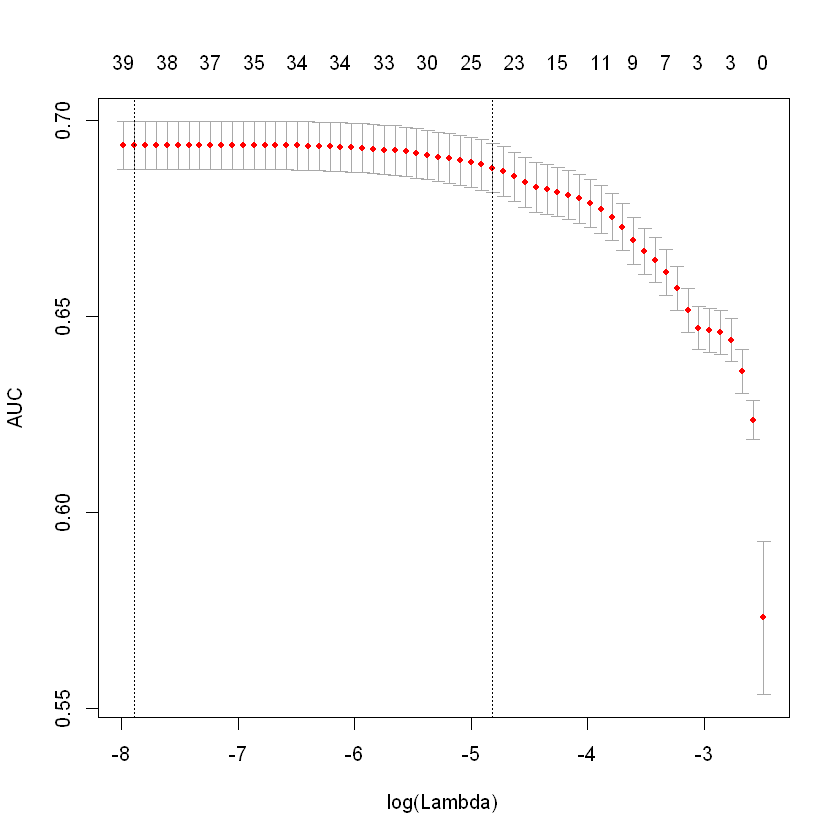

In [7]:
# 3rd method: LASSO
# Fit the LASSO model (Lasso: Alpha = 1)
set.seed(8000)

cv.lasso <- cv.glmnet(as.matrix(data[,1:45]), as.double(data$target), family='binomial', alpha=1, parallel=TRUE, standardize=TRUE, type.measure='auc')

# Results
plot(cv.lasso)

The graph above shows the AUC x Lambda values.

Then, it is necessary to plot the variables and identify which ones will be used. The closer to zero, the least important the variable is, therfore I picked the 20 most important variables (high positive and low negative values).

In [8]:
# Plotting the variables: high positive or low negative implies more important is that variable.

# plot(cv.lasso$glmnet.fit, xvar="lambda", label=TRUE)
cat('Min Lambda: ', cv.lasso$lambda.min, '\n 1Sd Lambda: ', cv.lasso$lambda.1se)
df_coef <- round(as.matrix(coef(cv.lasso, s=cv.lasso$lambda.min)), 2)

# See all contributing variables
df_coef[df_coef[, 1] != 0, ]

Min Lambda:  0.0003763203 
 1Sd Lambda:  0.008107575

(Intercept)          N1          N2          N4          N6          N7 
       0.01        0.03        0.08        0.02        0.12       -0.08 
         N8          N9         N10         N11         N12         N13 
       0.03       -0.02       -0.09        0.07        0.11       -0.10 
        N14         N15         N16         N17         N18         N19 
       0.10       -0.01       -0.03       -0.16       -0.14       -0.62 
        N20         N21         N22         N24         N25         N26 
       1.07        0.05        0.05        0.29        0.27       -0.09 
        N28         N29         N30         N32         N33         N35 
      -0.01        0.27        0.11       -0.01       -0.02       -0.04 
        N36         N37         N39         N40         N41         N42 
      -0.02       -0.03       -0.03        0.03        0.03        0.05 
        N43         N44         N45 
       0.06        0.05        0.01

In [9]:
data3 = data[,c('N2','N6','N7','N10','N11','N12','N13','N14','N16','N17','N18','N19','N20','N24','N25',
                      'N26','N29','N30','N35','N37','target')]
data3$target = as.factor(data3$target)
dim(data3)

[1] 13083    21

## 2.4. Splitting the data
This step, as described in the title, is for splitting the data in training and validation datasets. I used 80% of the dataset as training and the remaining 20% for validation. I named them 'dataset(1/2/3)' and 'test(1/2/3)', and separated the features from labels in both, naming as x(1/2/3) and y(1/2/3) for the training dataset and t_x(1/2/3) and t_y(1/2/3) for the validation. 

In [8]:
# Splitting the data: dataset1

# create a list of 80% of the rows in the original dataset we can use for training
validation_index1 <- createDataPartition(data1$target, p=0.80, list=FALSE)

# select 20% of the data for testing
test1 <- data1[-validation_index1,]

# use the remaining 80% of data to training
dataset1 <- data1[validation_index1,]

# split input and output
x1 <- dataset1[,1:37]
y1 <- dataset1[,38]

t_x1 <- test1[,1:37]
t_y1 <- test1[,38]

In [11]:
# Splitting the data: dataset2

# create a list of 80% of the rows in the original dataset we can use for training
validation_index2 <- createDataPartition(data2$target, p=0.80, list=FALSE)

# select 20% of the data for testing
test2 <- data2[-validation_index2,]

# use the remaining 80% of data to training
dataset2 <- data2[validation_index2,]

# split input and output
x2 <- dataset2[,1:23]
y2 <- dataset2[,24]

# split input and output
t_x2 <- test2[,1:23]
t_y2 <- test2[,24]

In [12]:
# Splitting the data: dataset3

# create a list of 80% of the rows in the original dataset we can use for training
validation_index3 <- createDataPartition(data3$target, p=0.80, list=FALSE)

# select 20% of the data for testing
test3 <- data3[-validation_index3,]

# use the remaining 80% of data to training
dataset3 <- data3[validation_index3,]

# split input and output
x3 <- dataset3[,1:20]
y3 <- dataset3[,21]

t_x3 <- test3[,1:20]
t_y3 <- test3[,21]

# 3. Model selection

The models chosen:

1. Random Forest: Usually tree models are less sensitive to the presence of outliers.
2. Linear: The easiest model to scale and computationaly cheapest. Linear discriminant analisys will be performed.
3. SVM: The most computationally expensive model from the selected ones. The benefit is that it is possible to capture much more complex relationships between the datapoints without having to perform difficult transformations.

The evaluation of the model predictions is going to be done through Accuracy using cross-validation and F1 score.

## 4.1. Random Forest
   
The Random Forest model works by fitting a number of decision tree classifiers (hence the name "forest") on various sub-samples of the dataset and merges them to obtain a more accurate prediction and to control over-fitting. On this case, it will output the class.

The first step will be creating a model with default parameters and measuring its accuracy. Below, the results show that the entire dataset yields the smallest error, therefore some parameter tuning needs to be performed. 

In [15]:
# Model 2: Random Forest
# Create a Random Forest model with default parameters
set.seed(8000)
model1_1 <- randomForest(x1, y1, importance = TRUE)
model1_1

set.seed(8000)
model1_2 <- randomForest(x2, y2, importance = TRUE)
model1_2

set.seed(8000)
model1_3 <- randomForest(x3, y3, importance = TRUE)
model1_3


Call:
 randomForest(x = x1, y = y1, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 6

        OOB estimate of  error rate: 34.96%
Confusion matrix:
     0    1 class.error
0 3372 1886   0.3586915
1 1773 3436   0.3403724


Call:
 randomForest(x = x2, y = y2, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 34.81%
Confusion matrix:
     0    1 class.error
0 3413 1845   0.3508939
1 1799 3410   0.3453638


Call:
 randomForest(x = x3, y = y3, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 34.96%
Confusion matrix:
     0    1 class.error
0 3355 1903   0.3619247
1 1756 3453   0.3371089

I performed a 'for' loop to identify which are the best values for the number of trees and variables, to make sure that the feature selection performed on dataset2 is the best option. 

[1] 0.6510939 0.6521448 0.6538645 0.6512850 0.6495653 0.6481322

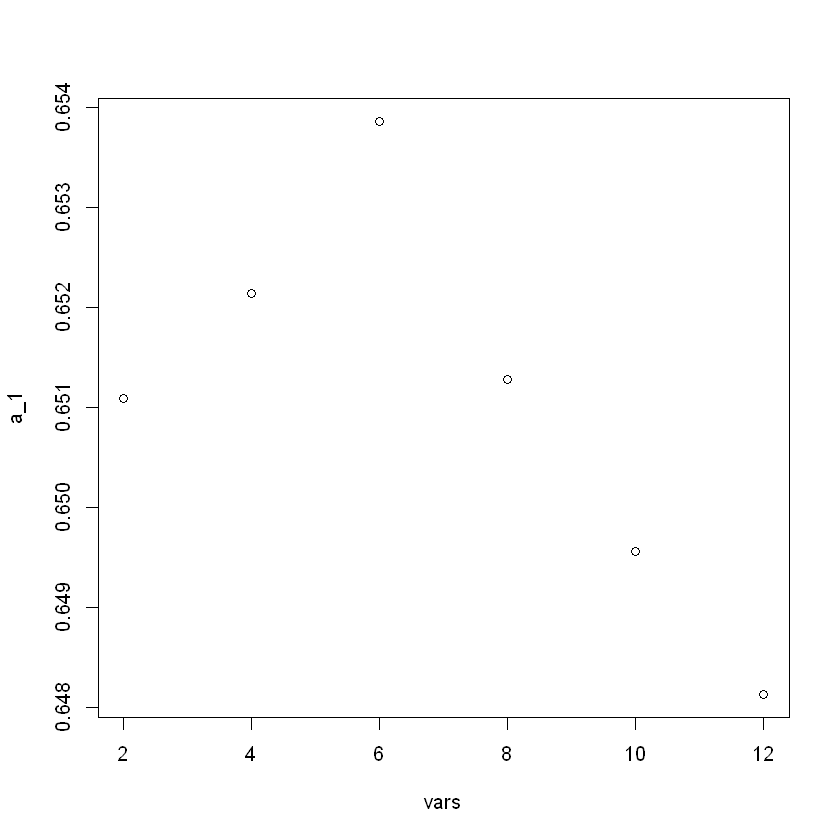

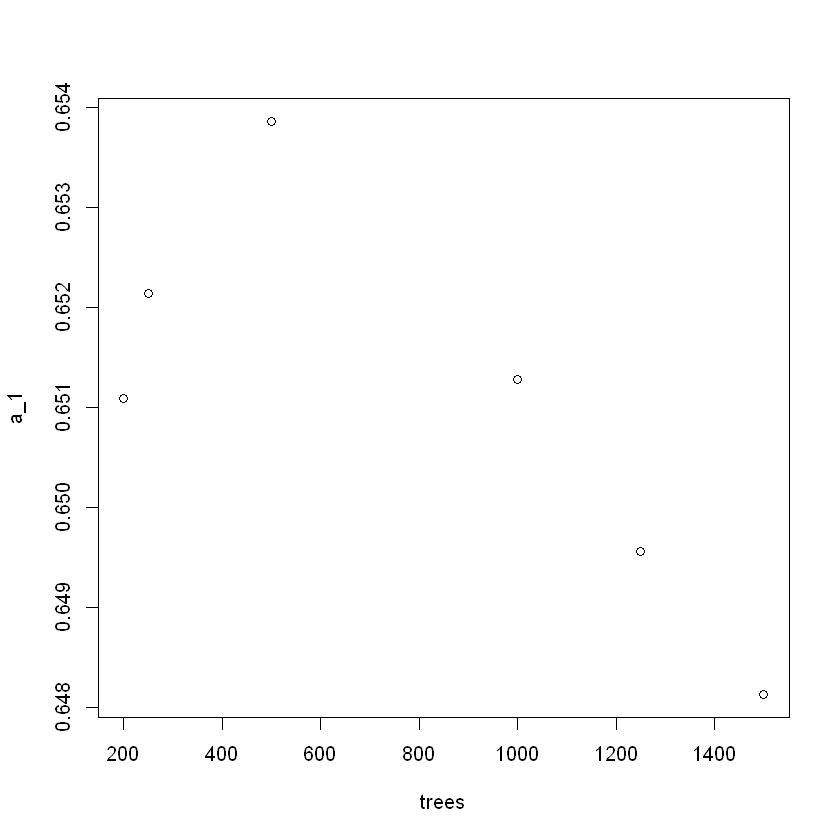

In [24]:
# Using For loop to identify the right ntree and mtry for model: dataset1
a_1=c()
vars = c(2,4,6,8,10,12)
trees =c(200,250,500,1000,1250,1500)

for(j in 1:length(trees)) {
    ntree = trees[j]
        for (i in 1:length(vars)) {
            mtry = vars[i]
            set.seed(8000)
            model3_1 <- randomForest(x1,y1,ntree=ntree,mtry=mtry)
            set.seed(8000)
            predValid3_1 <- predict(model3_1, type = "class")
            a_1[i] = mean(predValid3_1 == y1)
        }
     }
a_1
 
plot(vars,a_1)
plot(trees,a_1)

[1] 0.6552021 0.6555842 0.6534824 0.6531958 0.6573039 0.6536734

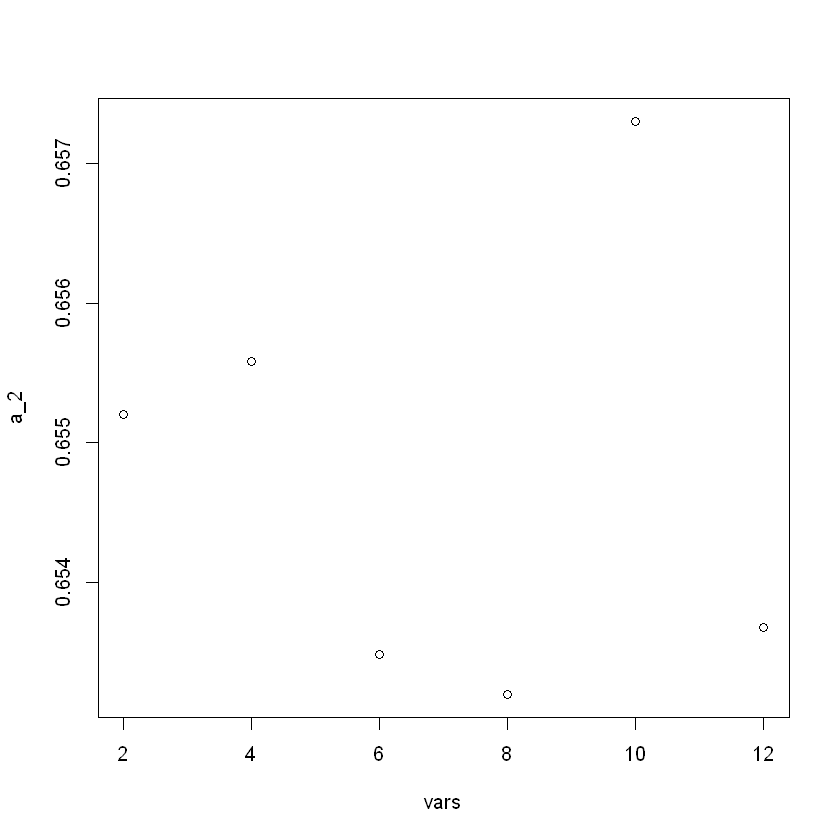

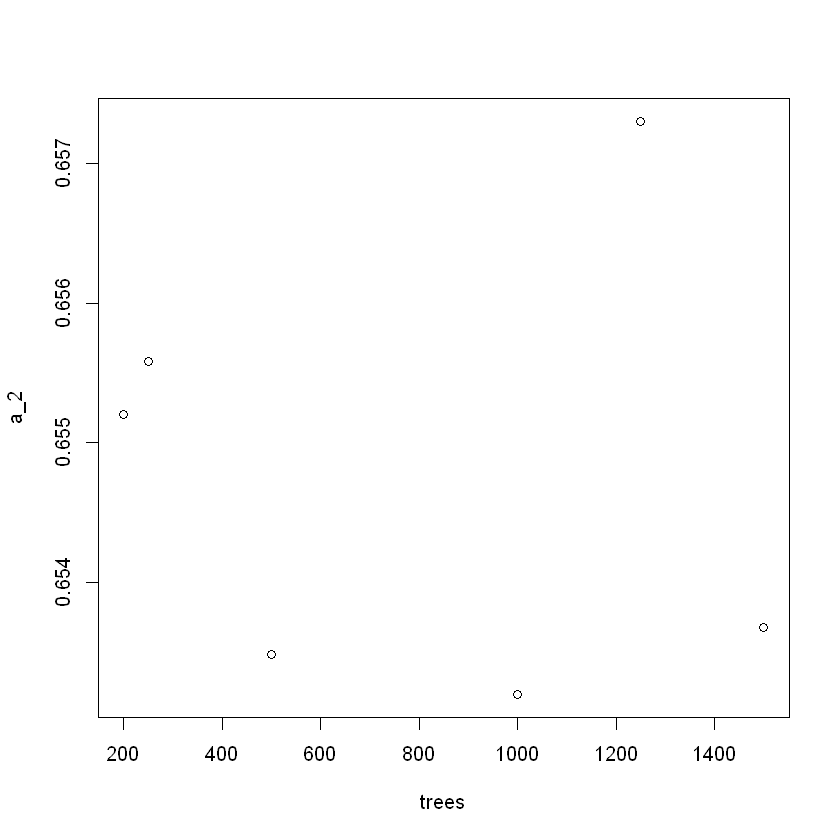

In [27]:
# Using For loop to identify the right ntree and mtry for model: dataset2
a_2=c()
vars = c(2,4,6,8,10,12)
trees =c(200,250,500,1000,1250,1500)

for(j in 1:length(trees)) {
    ntree = trees[j]
        for (i in 1:length(vars)) {
            mtry = vars[i]
            set.seed(8000)
            model3_2 <- randomForest(x2,y2,ntree=ntree,mtry=mtry)
            set.seed(8000)
            predValid3_2 <- predict(model3_2, type = "class")
            a_2[i] = mean(predValid3_2 == y2)
        }
     }
a_2
 
plot(vars,a_2)
plot(trees,a_2)

[1] 0.6517627 0.6564441 0.6493742 0.6534824 0.6511895 0.6514761

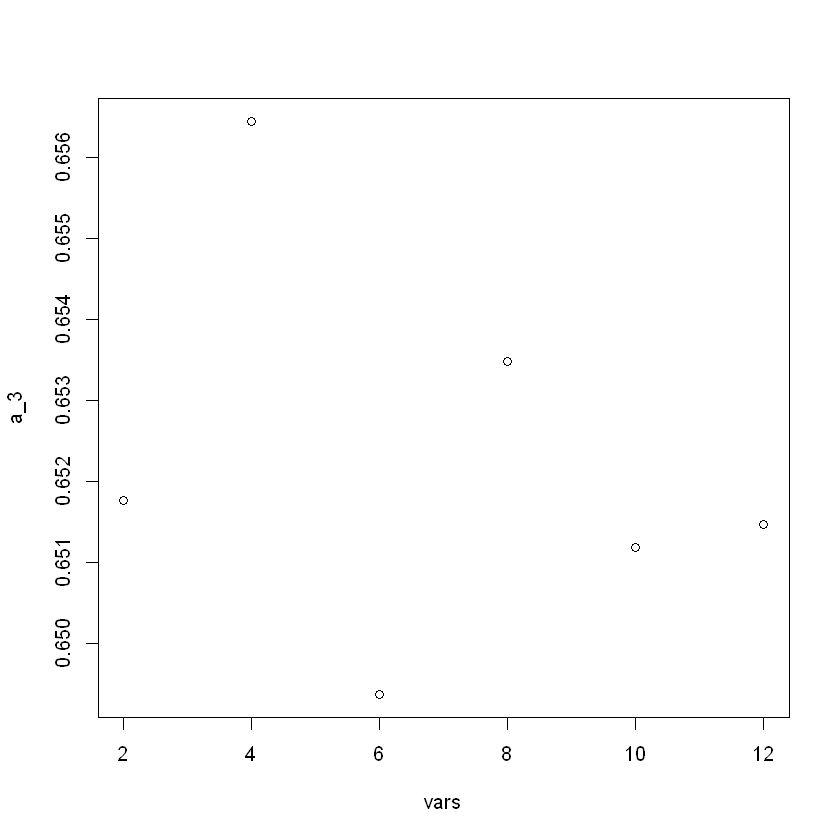

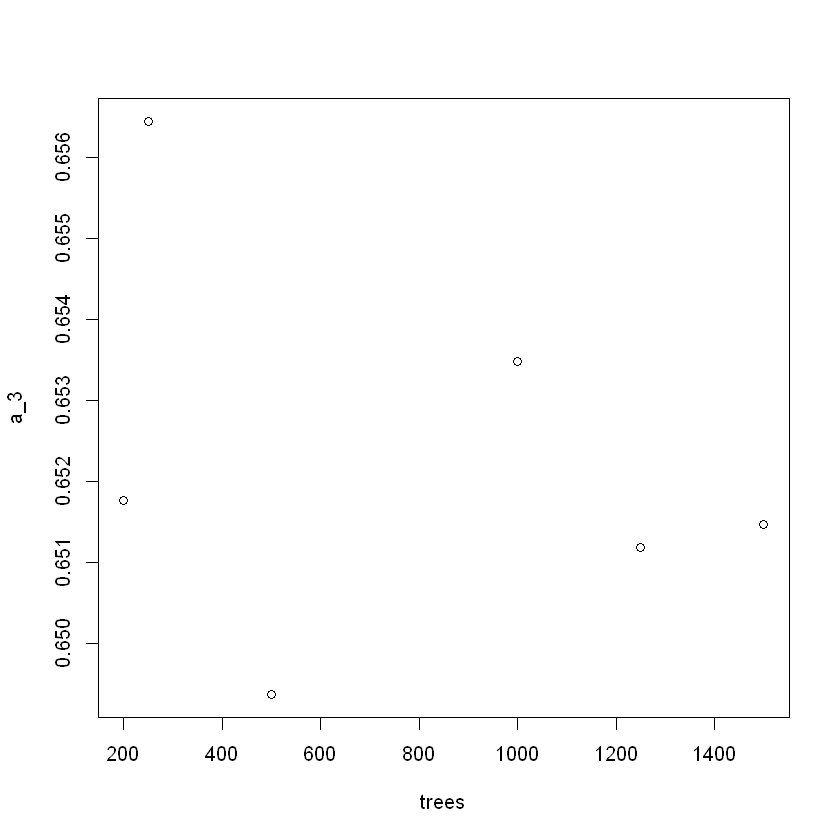

In [28]:
# Using For loop to identify the right ntree and mtry for model: dataset3
set.seed(8000)
a_3=c()
vars = c(2,4,6,8,10,12)
trees =c(200,250,500,1000,1250,1500)

for(j in 1:length(trees)) {
    ntree = trees[j]
        for (i in 1:length(vars)) {
            mtry = vars[i]
            set.seed(8000)
            model3_3 <- randomForest(x3,y3,ntree=ntree,mtry=mtry)
            set.seed(8000)
            predValid3_3 <- predict(model3_3, type = "class")
            a_3[i] = mean(predValid3_3 == y3)
        }
     }
a_3
 
plot(vars,a_3)
plot(trees,a_3)

After finding the best parameters, I ran the random forest model again and measured the accuracies for the validation data.

In [9]:
# Fine tuning parameters of Random Forest model with the optimal number of variables

# For dataset 1: (error before: 34.96%)
set.seed(8000)
model2_1 <- randomForest(x1, y1, ntree = 500, mtry = 6, importance = TRUE)
model2_1

# For dataset 2: (error before: 34.81%)
set.seed(8000)
model2_2 <- randomForest(x2, y2, ntree = 1250, mtry = 10, importance = TRUE)
model2_2

# For dataset 3: (error before: 35.96%)
set.seed(8000)
model2_3 <- randomForest(x3, y3, ntree = 250, mtry = 4, importance = TRUE)
model2_3


Call:
 randomForest(x = x1, y = y1, ntree = 500, mtry = 6, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 6

        OOB estimate of  error rate: 35.42%
Confusion matrix:
     0    1 class.error
0 3344 1914   0.3640167
1 1793 3416   0.3442119

ERROR: Error in randomForest(x2, y2, ntree = 1250, mtry = 10, importance = TRUE): objeto 'x2' não encontrado


In [30]:
# Predicting on Validation set: dataset1
set.seed(8000)
predValid1 <- predict(model2_1, t_x1, type = "class")
# Checking classification accuracy
mean(predValid1 == t_y1)                    
table(predValid1,t_y1)

# Predicting on Validation set: dataset2
set.seed(8000)
predValid2 <- predict(model2_2, t_x2, type = "class")
# Checking classification accuracy
mean(predValid2 == t_y2)                    
table(predValid2,t_y2)

# Predicting on Validation set: dataset3
set.seed(8000)
predValid3 <- predict(model2_3, t_x3, type = "class")
# Checking classification accuracy
mean(predValid3 == t_y3)   
table(predValid3,t_y3)

[1] 0.6551988

          t_y1
predValid1   0   1
         0 858 446
         1 456 856

[1] 0.6513761

          t_y2
predValid2   0   1
         0 839 437
         1 475 865

[1] 0.6414373

          t_y3
predValid3   0   1
         0 848 472
         1 466 830

In [168]:
# F1 score
# Dataset1
precision1 = 856 / (856 + 446)
recall1 = 856 / (856 + 456)
Fscore1 = (2*precision1*recall1) / sum(precision1, recall1)
print(Fscore1)

# Dataset2
precision2 = 865 / (865 + 437)
recall2 = 865 / (865 + 475)
Fscore2 = (2*precision2*recall2) / sum(precision2, recall2)
print(Fscore2)

# Dataset3
precision3 = 830 / (830 + 472)
recall3 = 830 / (830 + 466)
Fscore3 = (2*precision3*recall3) / sum(precision3, recall3)
print(Fscore3)

[1] 0.654935
[1] 0.654807
[1] 0.638953


## 4.2. Linear Discriminant Analysis

LDA works by creating separate probability density functions for each class / cluster, then tries to maximize the difference between these (effectively by minimizing the area of ‘overlap’ between them).

This model will apply the most basic concept of classification, and will try to find the ‘cutoff’ or ‘decision boundary’ at which it is most successful in the classification task. 

In [13]:
# fit model: 
#Dataset 1
set.seed(8000)
fit1 <- lda(x1,y1)
#Dataset 2
set.seed(8000)
fit2 <- lda(x2,y2)
#Dataset 3
set.seed(8000)
fit3 <- lda(x3,y3)

# make predictions:
#Dataset1
set.seed(8000)
test1_1 <- predict(fit1, t_x1)$class
#Dataset1
set.seed(8000)
test1_2 <- predict(fit2, t_x2)$class
#Dataset1
set.seed(8000)
test1_3 <- predict(fit3, t_x3)$class

# summarize accuracy
#Dataset1
mean(test1_1 == t_y1)                    
table(test1_1,t_y1)
#Dataset2
mean(test1_2 == t_y2)                    
table(test1_2,t_y2)
#Dataset3
mean(test1_3 == t_y3)                    
table(test1_3,t_y3)

Warning message in lda.default(x, grouping, ...):
"variables are collinear"

[1] 0.6383792

       t_y1
test1_1   0   1
      0 849 481
      1 465 821

[1] 0.6536697

       t_y2
test1_2   0   1
      0 890 482
      1 424 820

[1] 0.6341743

       t_y3
test1_3   0   1
      0 885 528
      1 429 774

In [169]:
# F1 score
# Dataset1
LDA_precision1 = 821 / (821 + 481)
LDA_recall1 = 821 / (821 + 465)
LDA_Fscore1 = (2*LDA_precision1*LDA_recall1) / sum(LDA_precision1, LDA_recall1)
print(LDA_Fscore1)

# Dataset2
LDA_precision2= 820 / (820 + 482)
LDA_recall2 = 820 / (820 + 424)
LDA_Fscore2 = (2*LDA_precision2*LDA_recall2) / sum(LDA_precision2, LDA_recall2)
print(LDA_Fscore2)

# Dataset3
LDA_precision3 = 774 / (774 + 528)
LDA_recall3 = 774 / (774 + 429)
LDA_Fscore3 = (2*LDA_precision3*LDA_recall3) / sum(LDA_precision3, LDA_recall3)
print(LDA_Fscore3)

[1] 0.6344668
[1] 0.6441477
[1] 0.6179641


The warning message above shows collinearity between variables, which means that there is already some high correlation between them.

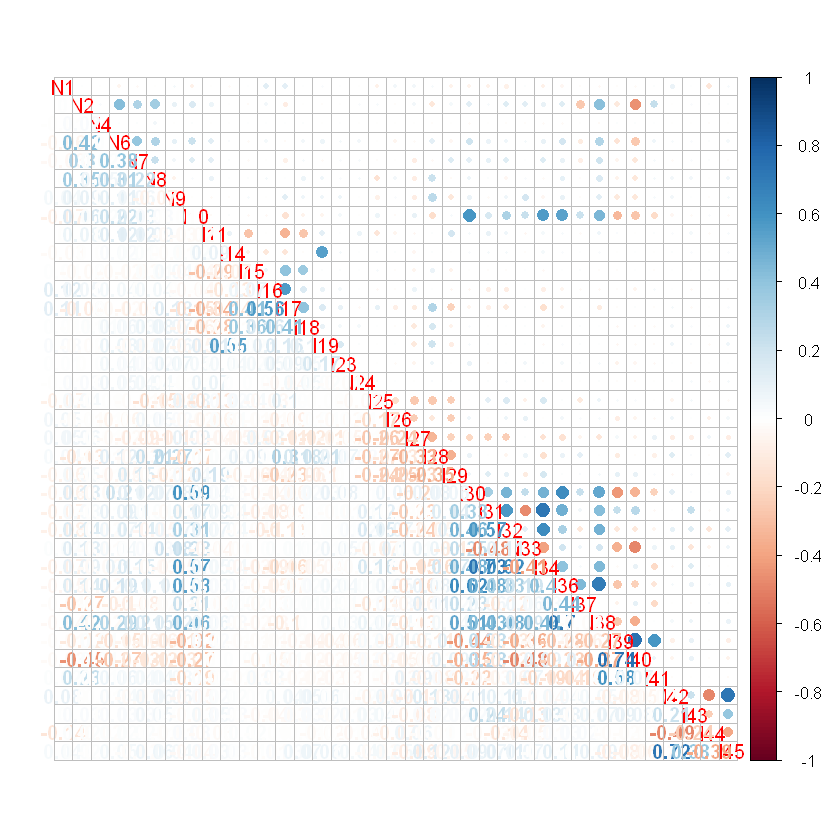

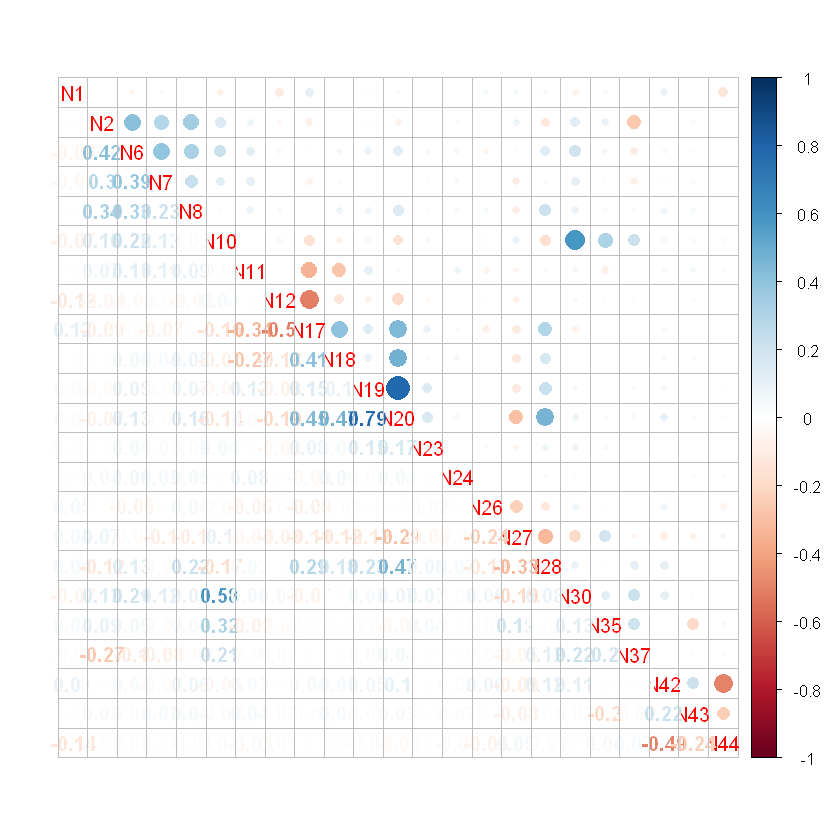

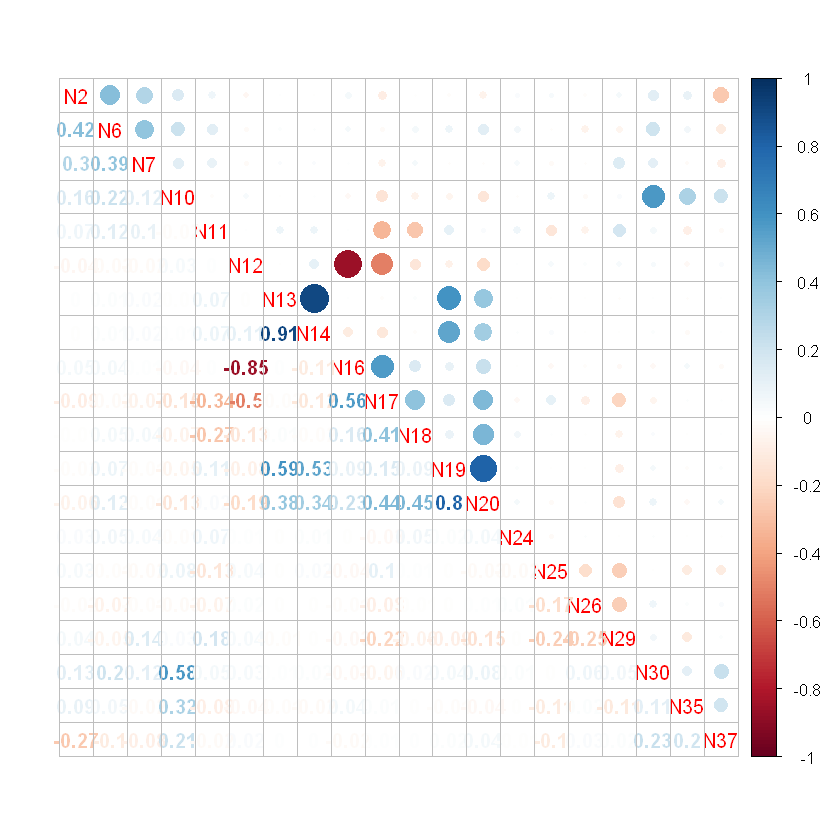

In [163]:
# Warning message shows collinearity of variables: checking correlation tables
corr.matrix <- cor(x1)
corrplot.mixed(corr.matrix)

corr.matrix <- cor(x2)
corrplot.mixed(corr.matrix)

corr.matrix <- cor(x3)
corrplot.mixed(corr.matrix)

From the correlation plots above, is is clear that the methods where I did not exclude the correlated features showed the highest values, hence the warning message above.

## 4.3. Support Vector Machines

By definition, a support vector machine works towards finding a decision boundary (separating hyperplane) in such a way that the separation between the two classes is as wide as possible. 

There are linear and non-linear approaches possible for solving a problem, although, since there is no previous information about the dataset provided, and a linear approach has already been implemented, I decided to test a non-linear model.

The non-linear model (radial kernel) takes the data and applies a transformation to add another dimension (z-axis).

The first step will be creating a model with the default settings:

In [15]:
# create SVM Model and show summary: dataset1
set.seed(8000)
svm_model1 <- svm(x1, y1)
summary(svm_model1)

# create SVM Model and show summary: dataset2
set.seed(8000)
svm_model2 <- svm(x2, y2)
summary(svm_model2)

# create SVM Model and show summary: dataset3
set.seed(8000)
svm_model3 <- svm(x3, y3)
summary(svm_model3)


Call:
svm.default(x = x1, y = y1)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.02702703 

Number of Support Vectors:  8406

 ( 4182 4224 )


Number of Classes:  2 

Levels: 
 0 1





Call:
svm.default(x = x2, y = y2)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.04347826 

Number of Support Vectors:  8204

 ( 4052 4152 )


Number of Classes:  2 

Levels: 
 0 1





Call:
svm.default(x = x3, y = y3)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.05 

Number of Support Vectors:  8069

 ( 3990 4079 )


Number of Classes:  2 

Levels: 
 0 1




Then, running a prediction with the testing dataset and measuring the accuracy:

In [16]:
# Run Prediction and measure the execution time: dataset1
set.seed(8000)
pred1 <- predict(svm_model1,t_x1)
system.time(pred1 <- predict(svm_model1,t_x1))

# Run Prediction and measure the execution time: dataset2
set.seed(8000)
pred2 <- predict(svm_model2,t_x2)
system.time(pred2 <- predict(svm_model2,t_x2))

# Run Prediction and measure the execution time: dataset3
set.seed(8000)
pred3 <- predict(svm_model3,t_x3)
system.time(pred3 <- predict(svm_model3,t_x3))

   user  system elapsed 
   8.78    0.00    8.83 

   user  system elapsed 
   6.78    0.00    6.78 

   user  system elapsed 
   5.90    0.00    5.91 

In [17]:
# Confusion matrix and accuracy: dataset1
mean(pred1 == t_y1)                    
table(pred1,t_y1)

# Confusion matrix and accuracy: dataset2
mean(pred2 == t_y2)                    
table(pred2,t_y2)

# Confusion matrix and accuracy: dataset3
mean(pred3 == t_y3)                    
table(pred3,t_y3)

[1] 0.6364679

     t_y1
pred1   0   1
    0 890 527
    1 424 775

[1] 0.6525229

     t_y2
pred2   0   1
    0 894 489
    1 420 813

[1] 0.6357034

     t_y3
pred3   0   1
    0 875 514
    1 439 788

To increase accuracy, SVM has to be tuned to find the best cost and gamma.

The cost parameter tells the SVM optimization how much missclassifying is wanted in each training example. Large values mean a smaller margin hyperplane, therefore smaller values yield a higher margin separating hyperplane, even if there are more missclassified points.

This will be done using the 'tune' function, which tunes hyperparameters using a grid search over supplied parameter ranges.

In [18]:
# Tuning SVM to find the best cost and gamma: dataset1
set.seed(8000)
svm_tune1 <- tune(svm, train.x=x1, train.y=y1, 
              kernel="radial", ranges=list(cost=10^(-1:2), gamma=c(0.5,1,2)))

print(svm_tune1)


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 cost gamma
  100   0.5

- best performance: 0.4203694 



In [19]:
# Tuning SVM to find the best cost and gamma: dataset2
set.seed(8000)
svm_tune2 <- tune(svm, train.x=x2, train.y=y2, 
              kernel="radial", ranges=list(cost=10^(-1:2), gamma=c(0.5,1,2)))

print(svm_tune2)


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 cost gamma
    1   0.5

- best performance: 0.3869316 



In [20]:
# Tuning SVM to find the best cost and gamma: dataset3
set.seed(8000)
svm_tune3 <- tune(svm, train.x=x3, train.y=y3, 
              kernel="radial", ranges=list(cost=10^(-1:2), gamma=c(0.5,1,2)))

print(svm_tune3)


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 cost gamma
    1   0.5

- best performance: 0.3642911 



In [21]:
# Create svm model again using the best cost and gamma
# Dataset1
set.seed(8000)
svm_model_after_tune1 <- svm(x1, y1, kernel="radial", cost=100, gamma=0.5)
summary(svm_model_after_tune1)

# Dataset2
set.seed(8000)
svm_model_after_tune2 <- svm(x2, y2, kernel="radial", cost=1, gamma=0.5)
summary(svm_model_after_tune2)

# Dataset3
set.seed(8000)
svm_model_after_tune3 <- svm(x3, y3, kernel="radial", cost=1, gamma=0.5)
summary(svm_model_after_tune3)


Call:
svm.default(x = x1, y = y1, kernel = "radial", gamma = 0.5, cost = 100)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  100 
      gamma:  0.5 

Number of Support Vectors:  10451

 ( 5244 5207 )


Number of Classes:  2 

Levels: 
 0 1





Call:
svm.default(x = x2, y = y2, kernel = "radial", gamma = 0.5, cost = 1)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.5 

Number of Support Vectors:  10174

 ( 5005 5169 )


Number of Classes:  2 

Levels: 
 0 1





Call:
svm.default(x = x3, y = y3, kernel = "radial", gamma = 0.5, cost = 1)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.5 

Number of Support Vectors:  9600

 ( 4617 4983 )


Number of Classes:  2 

Levels: 
 0 1




In [22]:
# Running predictions with the new model
#Dataset1
set.seed(8000)
svm_pred1 <- predict(svm_model_after_tune1,t_x1)
system.time(predict(svm_model_after_tune1,t_x1))

#Dataset2
set.seed(8000)
svm_pred2 <- predict(svm_model_after_tune2,t_x2)
system.time(predict(svm_model_after_tune2,t_x2))

#Dataset2
set.seed(8000)
svm_pred3 <- predict(svm_model_after_tune3,t_x3)
system.time(predict(svm_model_after_tune3,t_x3))

   user  system elapsed 
  11.59    0.00   11.61 

   user  system elapsed 
   8.81    0.00    8.82 

   user  system elapsed 
   6.86    0.02    6.89 

In [23]:
# Confusion matrix and accuracy
#Dataset1
mean(svm_pred1 == t_y1)                    
table(svm_pred1,t_y1)

#Dataset2
mean(svm_pred2 == t_y2)                    
table(svm_pred2,t_y2)

#Dataset3
mean(svm_pred3 == t_y3)                    
table(svm_pred3,t_y3)

[1] 0.5925076

         t_y1
svm_pred1    0    1
        0  478  230
        1  836 1072

[1] 0.6127676

         t_y2
svm_pred2   0   1
        0 620 319
        1 694 983

[1] 0.6169725

         t_y3
svm_pred3   0   1
        0 745 433
        1 569 869

In [170]:
# F1 score

# Dataset1
SVM_precision1 = 1072 / (1072 + 230)
SVM_recall1 = 1072 / (1072 + 836)
SVM_Fscore1 = (2*SVM_precision1*SVM_recall1) / sum(SVM_precision1, SVM_recall1)
print(SVM_Fscore1)

# Dataset1
SVM_precision2 = 983 / (983 + 319)
SVM_recall2 = 983 / (983 + 694)
SVM_Fscore2 = (2*SVM_precision2*SVM_recall2) / sum(SVM_precision2, SVM_recall2)
print(SVM_Fscore2)

# Dataset1
SVM_precision3 = 869 / (869 + 433)
SVM_recall3 = 869 / (869 + 569)
SVM_Fscore3 = (2*SVM_precision3*SVM_recall3) / sum(SVM_precision3, SVM_recall3)
print(SVM_Fscore3)

[1] 0.6679128
[1] 0.659953
[1] 0.6343066


# 4. Combination of models

The markdown tables below show, respectively, the accuracies and F1 scores measured with each model combined with the feature selection:

|Model / Feature Selection|Correlation|Stepwise|   LASSO  |
|-------------------------|-----------|--------|----------|
|      Random Forest      |  65,52%   | 65,14% |  64,14%  |
|          LDA            |  63,84%   | 65,37% |  63,42%   
|          SVM            |  59,25%   | 61,28% |  61,70%  |

|Model / Feature Selection|Correlation|Stepwise|   LASSO  |
|-------------------------|-----------|--------|----------|
|      Random Forest      |  65,49%   | 65,48% |  63,89%  |
|          LDA            |  63,45%   | 64,41% |  61,80%   
|          SVM            |  66,79%   | 65,99% |  63,43%  |

To decide the best combination of feature selection and machine learning model, I will look at the data distribution.

In [171]:
# summarize the class distribution
percentage <- prop.table(table(data$target)) * 100
cbind(freq=table(data$target), percentage=percentage)

,freq,percentage
0,6572,50.23313
1,6511,49.76687


Since accuracy can be largely contributed by a large number of True Negatives, F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall when there is an uneven class distribution (large number of Actual Negatives).

Looking at the distribution in the dataset provided, choosing accuracy is a valid option, since the distribution is roughly the same for the "0" and "1" labels.

From th results above, the combination chosen was the Random model with the Correlation feature selection, since it gave the highest accuracy (65,52%).

## 4.2. Predicting Values Using the Most Accurate Model

Now, the most accurate model will be used on the testing dataset provided by the exercise and the predictions will be performed.

The model chosen is random forest with 500 trees and number of variables 6, on the dataset with the features selected by correlation.

In [10]:
# Load file for predictions
predic <- read.csv("test.csv", header=T, sep=",", stringsAsFactors=F)
head(predic)

id,N1,N2,N3,N4,N5,N6,N7,N8,N9,...,N36,N37,N38,N39,N40,N41,N42,N43,N44,N45
2,-0.6616483,-0.61878600,0.016055679,0.0006750663,0.031478312,-0.69570047,-0.5949557,-0.4265204,-0.3042644,...,-0.6400320,-0.87095652,-0.2289379,1.1021597,1.36740642,0.07864114,-0.8707956,-0.2690728,0.8377381,-0.68964942
3,-0.6616483,-0.71218294,0.007644432,0.0006750660,-0.007752305,-0.69570047,-0.5949557,-0.4265204,-0.3042644,...,1.3583836,0.06386407,0.9817856,-1.6217761,-0.95785852,-0.27086384,-0.8707956,-0.2690728,0.8377381,-0.68964942
4,-0.6616483,-0.03293246,-0.012619006,0.0006750670,-0.007210427,-0.16622723,-0.8543496,-0.4265204,-0.3042644,...,0.3074379,0.57376621,0.1746366,-0.8625735,-0.26889113,-0.62036882,-0.8707956,-0.2690728,0.8377381,-0.68964942
5,1.2304663,1.11542538,-0.037654383,0.0006750673,-0.045419360,0.71622818,4.0741340,1.8600374,-0.3042644,...,0.5481279,-0.87095652,0.9817856,0.3079398,0.07559256,0.60289861,0.5310522,0.2446342,-1.5699293,-0.08705493
9,0.2844090,-0.95416593,0.034620127,0.0006750637,0.045196809,-0.78394601,-0.8543496,-0.5468655,-0.3042644,...,2.0359410,4.27055673,0.1746366,1.0532267,1.36740642,-0.18348760,-0.4852875,-0.2690728,0.1756295,-0.68964942
11,-0.6616483,1.48901314,-0.016521098,0.0006750673,0.013006252,0.01026385,-0.8543496,-0.4265204,-0.3042644,...,0.4845424,0.06386407,0.9817856,-1.2177654,-1.64682591,0.07864114,-0.8707956,-0.2690728,0.8377381,-0.68964942


In [11]:
# Perform feature selection: add only the columns that are most relevant
predict2 = predic[ ,-c(1,21, 36, 13, 23, 14, 4, 6, 22)]

head(predict2)
dim(predict2)

N1,N2,N4,N6,N7,N8,N9,N10,N11,N14,...,N36,N37,N38,N39,N40,N41,N42,N43,N44,N45
-0.6616483,-0.61878600,0.0006750663,-0.69570047,-0.5949557,-0.4265204,-0.3042644,0.43283250,-1.6886047,-0.5031815,...,-0.6400320,-0.87095652,-0.2289379,1.1021597,1.36740642,0.07864114,-0.8707956,-0.2690728,0.8377381,-0.68964942
-0.6616483,-0.71218294,0.0006750660,-0.69570047,-0.5949557,-0.4265204,-0.3042644,-0.18341233,-0.6410073,-0.5031815,...,1.3583836,0.06386407,0.9817856,-1.6217761,-0.95785852,-0.27086384,-0.8707956,-0.2690728,0.8377381,-0.68964942
-0.6616483,-0.03293246,0.0006750670,-0.16622723,-0.8543496,-0.4265204,-0.3042644,-0.16975598,-0.1172086,-0.5031815,...,0.3074379,0.57376621,0.1746366,-0.8625735,-0.26889113,-0.62036882,-0.8707956,-0.2690728,0.8377381,-0.68964942
1.2304663,1.11542538,0.0006750673,0.71622818,4.0741340,1.8600374,-0.3042644,0.15939793,-0.1172086,-0.5031815,...,0.5481279,-0.87095652,0.9817856,0.3079398,0.07559256,0.60289861,0.5310522,0.2446342,-1.5699293,-0.08705493
0.2844090,-0.95416593,0.0006750637,-0.78394601,-0.8543496,-0.5468655,-0.3042644,0.36407953,-0.1172086,-0.5031815,...,2.0359410,4.27055673,0.1746366,1.0532267,1.36740642,-0.18348760,-0.4852875,-0.2690728,0.1756295,-0.68964942
-0.6616483,1.48901314,0.0006750673,0.01026385,-0.8543496,-0.4265204,-0.3042644,0.08236462,0.4065901,-0.5031815,...,0.4845424,0.06386407,0.9817856,-1.2177654,-1.64682591,0.07864114,-0.8707956,-0.2690728,0.8377381,-0.68964942


[1] 26561    37

In [12]:
# Run predictions with the most accurate model: Random Forest for dataset1
rf_predValid2 <- predict(model2_1, predict2, type = "class")

In [13]:
length(rf_predValid2)
head(rf_predValid2)

[1] 26561

1 2 3 4 5 6 
0 0 0 0 0 0 
Levels: 0 1

In [14]:
df <- data.frame(predic$id)
colnames(df) <- 'id'

df1 <- data.frame(as.matrix(rf_predValid2))
colnames(df1) <- 'target'

write.csv(c(df,df1), file="Deise_predicted.csv", row.names = F)

In [15]:
result <- read.csv("Deise_predicted.csv", header=T, sep=",", stringsAsFactors=F)

In [16]:
head(result)

id,target
2,0
3,0
4,0
5,0
9,0
11,0


# Conclusions

This assignment covered three feature selection algorithms, as well as three machine learning models. Even though all models had roughly the same accuracy, I selected the most effective combination based on this performance measure and applied it on the prediction dataset provided.